In [1]:
import random

import numpy as np
import torch
from unityagents import UnityEnvironment

from MADDPG.hyperparameters import *

In [2]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

env = UnityEnvironment(seed=RANDOM_SEED, file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [8]:
from collections import deque

import progressbar as pb


# TODO: Rename states
def train(maddpg, n_episodes=1000, max_t=1000, save_every=50):
    widget = [
        "Episode: ", pb.Counter(), '/' , str(n_episodes), ' ', 
        pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ', 
        'Rolling Average: ', pb.FormatLabel('')
    ]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()

    solved = False
    scores_total = []
    scores_deque = deque(maxlen=100)
    rolling_score_averages = []
    best_score = 0.0
    
    for i_episode in range(1, n_episodes+1):
        current_average = 0.0 if i_episode == 1 else rolling_score_averages[-1]
        widget[12] = pb.FormatLabel(str(current_average)[:6])
        timer.update(i_episode)
            
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations[:, -STATE_SIZE:]
        scores = np.zeros(num_agents)
        maddpg.reset()
        
        # for t in range(max_t):
        while True:
            actions = maddpg.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations[:, -STATE_SIZE:]
            rewards = env_info.rewards
            dones = env_info.local_done
            
            maddpg.step(states, actions, rewards, next_states, dones)
            
            scores += rewards
            states = next_states
            
            if np.any(dones):
                break
        
        max_episode_score = np.max(scores)
        
        scores_deque.append(max_episode_score)
        scores_total.append(max_episode_score)

        average_score = np.mean(scores_deque)
        rolling_score_averages.append(average_score)
        
        if average_score > best_score:
            best_score = average_score
            if solved:
                # This model is better than a previously saved model, so we'll save it
                maddpg.save_model()
        
        if average_score >= 0.5 and not solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode, average_score
            ))
            solved = True
            maddpg.save_model()
        
        if i_episode % save_every == 0 and not solved:
            maddpg.save_model()

    maddpg.save_model()

    return scores_total, rolling_score_averages

In [9]:
from MADDPG.maddpg_agent import MADDPGAgent

maddpg = MADDPGAgent(NUM_AGENTS, STATE_SIZE, ACTION_SIZE)

Agent #1
Actor (Local):
Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Actor (Target):
Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Critic (Local):
Critic(
  (fcs1): Linear(in_features=48, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
Critic (Target):
Critic(
  (fcs1): Linear(in_features=48, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
_______________________________________________________________
Agent #2
Actor (Local):
Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)

In [10]:
scores_total, rolling_score_averages = train(maddpg, n_episodes=3000)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_results(scores, rolling_score_averages):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(1, len(scores) + 1), scores, label="Max Score")
    plt.plot(np.arange(1, len(rolling_score_averages) + 1), rolling_score_averages, label="Rolling Average")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.show()

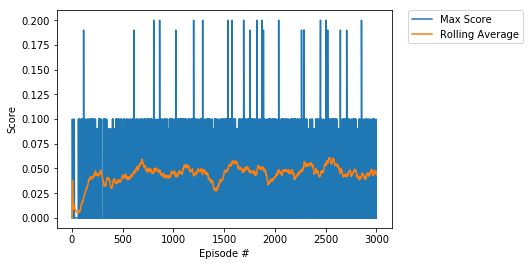

In [12]:
plot_results(scores_total, rolling_score_averages)